In [38]:
import json
import requests as r
import os
import matplotlib.pyplot as plt
from pathlib import Path
import utils as u
from imp import reload
reload(u)

<module 'utils' from '/home/przemek/Desktop/ds-agh/nlp/utils.py'>

In [28]:
es_url = "http://localhost:9200"
data_path = './data/ustawy/'
r.get(es_url).text

'{\n  "name" : "787f6588df9a",\n  "cluster_name" : "docker-cluster",\n  "cluster_uuid" : "enOIi3f8QcabCIi-CEBDaw",\n  "version" : {\n    "number" : "8.4.3",\n    "build_flavor" : "default",\n    "build_type" : "docker",\n    "build_hash" : "42f05b9372a9a4a470db3b52817899b99a76ee73",\n    "build_date" : "2022-10-04T07:17:24.662462378Z",\n    "build_snapshot" : false,\n    "lucene_version" : "9.3.0",\n    "minimum_wire_compatibility_version" : "7.17.0",\n    "minimum_index_compatibility_version" : "7.0.0"\n  },\n  "tagline" : "You Know, for Search"\n}\n'

## 3. Define an ES analyzer for Polish texts containing:
 - standard tokenizer
 - synonym filter with the following definitions:
  - kpk - kodeks postępowania karnego
  - kpc - kodeks postępowania cywilnego
  - kk - kodeks karny
  - kc - kodeks cywilny
 - Morfologik-based lemmatizer
 - lowercase filter  
Done in utils.

In [ ]:
print(u.config_es(es_url))

## 4. Define an ES index for storing the contents of the legislative acts.
Done in utils.

In [23]:
print(u.config_es_index(es_url).text)

{"acknowledged":true}


## 5. Load the data to the ES index.
Loading files to ES.
In the end histogram containing numbers of return codes. 
Created to ensure that everything was loaded.

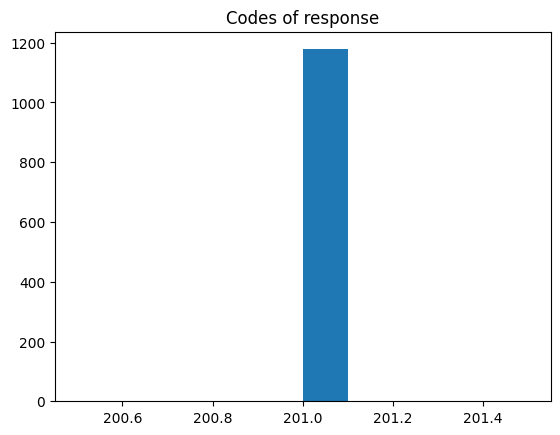

In [40]:
resp = []
for n,i in enumerate(os.listdir(data_path)):
    print(n,end='\r')
    resp.append(
        r.post(
            url = f"{es_url}/acts/_doc/{i[:-4]}",
            json = {
                "content" : open(data_path+i,'r', encoding="utf-8").read()
            }
        ).status_code
    )
plt.hist(resp)
plt.title('Codes of response')
plt.show()

## 6. Determine the number of legislative acts containing the word ustawa (in any form).

In [144]:
response = r.get(
    url=f"{es_url}/acts/_search?filter_path=hits.total.value",
    json={
        "query": {
            "match": {
                "content": "ustawa"
            }
        }
    }
)

In [145]:
response.text

'{"hits":{"total":{"value":1178}}}'

## 7. Determine the number of occurrences of the word ustawa by searching for this particular form, including the other inflectional forms.
termvectors zawierają statystyki na temat przeanalizowanego tekstu. Tutaj zapytują o pierwszą ustawę z brzegu, aby uzyskać dla niej statystyki. W tych statystykach znajdzie się również informacja o statystykach dla całego zbioru w polu ttf.

In [146]:
response = r.get(
    url=f"{es_url}/acts/_termvectors/1993_599",
    json={
        "term_statistics": True,
        "fields": ["content"]
    }
)

In [147]:
response.json()['term_vectors']['content']['terms']['ustawa']['ttf']

24934

## 8. Determine the number of occurrences of the word ustaw by searching for this particular form, including the other inflectional forms.
First I found keys that contain 'ustaw' word and then I add them up.

In [148]:
acc = 0
for i in response.json()['term_vectors']['content']['terms'].keys():
    if 'ustaw' in i:
        print(i)
        acc += response.json()['term_vectors']['content']['terms'][i]['ttf']
print(f"Number of words containing 'ustaw': {acc}")

ustawa
ustawić
Number of words containing 'ustaw': 25847


## 9. Determine the number of legislative acts containing the words kodeks postępowania cywilnego in the specified order, but in any inflection form.
For this task I used match_pharse query to preserve order. 

In [149]:
response = r.get(
    url=f"{es_url}/acts/_search?filter_path=hits.total.value",
    json={
        "query": {
            "match_phrase": {
                "content": "kodeks postępowania cywilnego"
            }
        }
    }
)
print(response.json())

{'hits': {'total': {'value': 99}}}


## 10. Determine the number of legislative acts containing the words wchodzi w życie (in any form) allowing for up to 2 additional words in the searched phrase.
The same task as above. To satisfy the condition of 2 additional words it is required to add slop parameter.  
Description under the link: https://kb.objectrocket.com/elasticsearch/how-to-use-slop-with-phrase-search-in-elasticsearch-6

In [150]:
response = r.get(
    url=f"{es_url}/acts/_search?filter_path=hits.total.value",
    json={
        "query": {
            "match_phrase": {
                "content": {
                    "query": "wchodzi w życie",
                    "slop": 2
                }
            }
        }
    }
)
print(response.json())

{'hits': {'total': {'value': 1174}}}


## 11. Determine the 10 documents that are the most relevant for the phrase konstytucja.
Matching words and ordering by _score descending. Then taking 10 ids from top.

In [164]:
response = r.get(
    url=f"{es_url}/acts/_search?filter_path=hits.hits._id,hits.hits._score",
    json={
        "sort": {"_score":"desc"},
        "query": {
            "match": {
                "content": "konstytucja"
            }
        },
        "size":10
    }
)

In [165]:
response.json()

{'hits': {'hits': [{'_id': '1997_629', '_score': 6.867447},
   {'_id': '2000_443', '_score': 6.661961},
   {'_id': '1997_604', '_score': 6.6308846},
   {'_id': '1996_350', '_score': 6.625914},
   {'_id': '1997_642', '_score': 6.2508636},
   {'_id': '2001_23', '_score': 6.055853},
   {'_id': '1996_199', '_score': 5.9257874},
   {'_id': '1999_688', '_score': 5.8478746},
   {'_id': '2001_1082', '_score': 5.4644876},
   {'_id': '1997_681', '_score': 5.4644876}]}}

## 12. Print the excerpts containing the word konstytucja (up to three excerpts per document) from the previous task.


In [171]:
response = r.get(
    url=f"{es_url}/acts/_search?filter_path=hits.hits._id,hits.hits._score,hits.hits.highlight",
    json={
        "sort": {"_score":"desc"},
        "query": {
            "match": {
                "content": "konstytucja"
            }
        },
        "highlight": {
            "fields": {
                "content": {
                    "number_of_fragments": 3
                }
            }
        },
        "size":10
    }
)

In [172]:
response.json()

{'hits': {'hits': [{'_id': '1997_629',
    '_score': 6.867447,
    'highlight': {'content': ['o zmianie ustawy konstytucyjnej o trybie przygotowania\n           i uchwalenia <em>Konstytucji</em> Rzeczypospolitej',
      'W ustawie  konstytucyjnej z  dnia 23 kwietnia 1992 r. o trybie przygotowania i \nuchwalenia <em>Konstytucji</em>',
      'Do zgłoszenia projektu <em>Konstytucji</em> załącza się wykaz \n                obywateli popierających zgłoszenie']}},
   {'_id': '2000_443',
    '_score': 6.661961,
    'highlight': {'content': ['umowy międzynarodowej i nie wypełnia przesłanek określonych w art. 89\n     ust. 1 lub art. 90 <em>Konstytucji</em>',
      'międzynarodowej lub załącznika nie\n     wypełnia przesłanek określonych w art. 89 ust. 1 lub art. 90 <em>Konstytucji</em>',
      'co do zasadności wyboru\n  trybu ratyfikacji umowy międzynarodowej, o którym mowa w art. 89 ust. 2\n  <em>Konstytucji</em>']}},
   {'_id': '1997_604',
    '_score': 6.6308846,
    'highlight': {'content